# Comprehensive CKD Risk Factor Prediction Analysis

## Dataset: UCI Chronic Kidney Disease Risk Factor Prediction (ID: 857)

### Objectives:
1. **Problem 1**: Multi-class Classification for CKD stage (s1/s2/s3/s4/s5)
2. **Problem 2**: Binary Classification for CKD diagnosis (ckd vs notckd)

### Features Used:
- **age**: Patient age
- **al**: Albumin levels in urine
- **urinestate**: Derived feature (1 if any of rbc, pc, pcc, ba equals 1, else 0)

### Analysis Pipeline:
- Data import and preprocessing
- Exploratory Data Analysis (EDA)
- Feature engineering
- Model training and hyperparameter tuning
- Model evaluation and comparison
- Visualization of results

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report, roc_auc_score, roc_curve,
                             precision_recall_curve, auc)
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Data Loading and Initial Exploration

### Data Source Priority:
1. **UCI ML Repository** - Primary source (ID: 857)
2. **Local CSV file** - Backup if UCI fails
3. **Medically realistic synthetic data** - Fallback option

The code will automatically detect which data source is available and handle the data accordingly, including proper column name standardization and validation.

In [ ]:
# Load dataset from UCI repository
print("Attempting to load UCI CKD Risk Factor Prediction dataset (ID: 857)...")
data_source = "unknown"

try:
    from ucimlrepo import fetch_ucirepo 
    
    # Fetch dataset 
    ckd_risk = fetch_ucirepo(id=857)
    
    # Data (as pandas dataframes) 
    X_data = ckd_risk.data.features 
    y_data = ckd_risk.data.targets 
    
    # Combine features and target into a single dataframe
    df = pd.concat([X_data, y_data], axis=1)
    
    # Verify we have the expected target columns
    print("Dataset loaded successfully from UCI repository!")
    print(f"Dataset Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Check if we have both stage and class columns
    has_stage = 'stage' in df.columns
    has_class = 'class' in df.columns
    
    if has_stage and has_class:
        print("✓ Both 'stage' and 'class' target variables found in UCI data")
        data_source = "uci_complete"
    elif has_stage or has_class:
        print(f"⚠ Only {'stage' if has_stage else 'class'} target variable found")
        data_source = "uci_partial"
    else:
        print("⚠ Target variables 'stage' and 'class' not found in expected format")
        print("Available columns that might be targets:", [col for col in df.columns if col.lower() in ['class', 'stage', 'classification', 'target', 'label']])
        data_source = "uci_unknown_format"
    
    print(f"Data source: {data_source}")
    
except Exception as e:
    print(f"Could not load from UCI repository: {e}")
    print("\nTrying alternative: loading from local CSV file...")
    
    # Try to load from local file first
    try:
        df = pd.read_csv("chronic_kidney_disease.csv")
        print(f"✓ Loaded from local CSV file!")
        print(f"Dataset Shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        data_source = "local_csv"
        
    except FileNotFoundError:
        print("No local CSV file found. Generating medically realistic synthetic data...")
        data_source = "synthetic"
        
        # Generate synthetic data that matches the expected structure
        np.random.seed(42)
        n_samples = 200
    
    # Generate features
    data = {
        'age': np.random.randint(20, 80, n_samples),
        'bp': np.random.randint(60, 140, n_samples),
        'sg': np.random.choice([1.005, 1.010, 1.015, 1.020, 1.025], n_samples),
        'al': np.random.choice([0, 1, 2, 3, 4, 5], n_samples),
        'su': np.random.choice([0, 1, 2, 3, 4, 5], n_samples),
        'rbc': np.random.choice([0, 1], n_samples),
        'pc': np.random.choice([0, 1], n_samples),
        'pcc': np.random.choice([0, 1], n_samples),
        'ba': np.random.choice([0, 1], n_samples),
        'bgr': np.random.randint(70, 200, n_samples),
        'bu': np.random.randint(10, 150, n_samples),
        'sc': np.random.uniform(0.5, 8.0, n_samples),
        'sod': np.random.randint(120, 160, n_samples),
        'pot': np.random.uniform(2.5, 6.0, n_samples),
        'hemo': np.random.uniform(8.0, 18.0, n_samples),
        'pcv': np.random.randint(25, 55, n_samples),
        'wbcc': np.random.randint(4000, 15000, n_samples),
        'rbcc': np.random.uniform(2.5, 6.5, n_samples),
        'htn': np.random.choice([0, 1], n_samples),
        'dm': np.random.choice([0, 1], n_samples),
        'cad': np.random.choice([0, 1], n_samples),
        'appet': np.random.choice([0, 1], n_samples),
        'pe': np.random.choice([0, 1], n_samples),
        'ane': np.random.choice([0, 1], n_samples),
    }
    
    # Generate stage (s1-s5) based on some logic
    stage_probs = []
    for i in range(n_samples):
        # Simple heuristic: worse indicators -> higher stage
        score = (data['al'][i] / 5 + data['sc'][i] / 8 + 
                 (1 if data['htn'][i] == 1 else 0) + 
                 (1 if data['dm'][i] == 1 else 0)) / 4
        
        if score < 0.2:
            stage_probs.append(np.random.choice(['s1', 's2'], p=[0.7, 0.3]))
        elif score < 0.4:
            stage_probs.append(np.random.choice(['s2', 's3'], p=[0.5, 0.5]))
        elif score < 0.6:
            stage_probs.append(np.random.choice(['s3', 's4'], p=[0.5, 0.5]))
        elif score < 0.8:
            stage_probs.append(np.random.choice(['s4', 's5'], p=[0.5, 0.5]))
        else:
            stage_probs.append('s5')
    
        data['stage'] = stage_probs
        
        # Generate class (ckd/notckd) based on medical logic instead of random
        # More advanced patients (higher stages) more likely to have CKD
        class_labels = []
        for stage in stage_probs:
            if stage in ['s1', 's2']:
                # Early stages: mix of ckd and notckd
                class_labels.append(np.random.choice(['ckd', 'notckd'], p=[0.3, 0.7]))
            elif stage in ['s3', 's4']:
                # Advanced stages: mostly ckd
                class_labels.append(np.random.choice(['ckd', 'notckd'], p=[0.8, 0.2]))
            else:  # s5
                # End stage: almost always ckd
                class_labels.append(np.random.choice(['ckd', 'notckd'], p=[0.95, 0.05]))
        
        data['class'] = class_labels
        
        df = pd.DataFrame(data)
        print("✓ Medically realistic synthetic dataset generated successfully!")
        print(f"Dataset Shape: {df.shape}")
        data_source = "synthetic"

# Standardize column names and handle different data formats
print(f"\n" + "="*60)
print(f"DATA SOURCE: {data_source.upper()}")
print(f"="*60)

if data_source in ["uci_complete", "uci_partial", "uci_unknown_format", "local_csv"]:
    # Handle real data - standardize column names
    df.columns = df.columns.str.lower().str.strip()
    
    # Map common variations of target column names
    column_mapping = {
        'classification': 'class',
        'target': 'class',
        'label': 'class',
        'ckd_class': 'class',
        'diagnosis': 'class'
    }
    
    for old_name, new_name in column_mapping.items():
        if old_name in df.columns:
            df.rename(columns={old_name: new_name}, inplace=True)
    
    # Standardize class values
    if 'class' in df.columns:
        df['class'] = df['class'].astype(str).str.lower().str.strip()
        # Map various representations to standard format
        class_mapping = {
            'ckd': 'ckd', 'chronic kidney disease': 'ckd', '1': 'ckd', 'positive': 'ckd',
            'notckd': 'notckd', 'no ckd': 'notckd', 'normal': 'notckd', '0': 'notckd', 'negative': 'notckd'
        }
        df['class'] = df['class'].map(class_mapping).fillna(df['class'])
    
    print(f"Real data loaded and standardized!")
    
# Dataset shape and export
print(f"\nFinal Dataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Export original dataset to CSV
csv_filename = f"ckd_dataset_original_{data_source}.csv"
df.to_csv(csv_filename, index=False)
print(f"\nOriginal dataset exported to '{csv_filename}'")
print(f"File contains {df.shape[0]} rows and {df.shape[1]} columns")

# Validate data integrity and required columns
print(f"\n" + "="*60)
print("DATA VALIDATION")
print("="*60)

required_columns = ['age', 'al', 'stage', 'class']
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    print(f"⚠ Missing required columns: {missing_columns}")
    print("Available columns:", list(df.columns))
    
    # Try to create missing columns if possible
    if 'class' not in df.columns and 'stage' in df.columns:
        print("Attempting to derive 'class' from 'stage'...")
        df['class'] = df['stage'].apply(lambda x: 'notckd' if x in ['s1', 's2'] else 'ckd')
        print("✓ Class column derived from stage")
    
    if 'stage' not in df.columns and 'class' in df.columns:
        print("⚠ Cannot derive 'stage' from 'class' - this analysis requires stage information")
else:
    print("✓ All required columns present")

# Apply the specific modification: Change stage from 's1' to 's0' when class is 'notckd'
if 'stage' in df.columns and 'class' in df.columns:
    print(f"\n" + "-"*40)
    print("APPLYING DATASET MODIFICATION")
    print("-"*40)
    print(f"Original stage distribution:\n{df['stage'].value_counts().sort_index()}")
    
    # Apply the modification
    mask = (df['class'] == 'notckd')# & (df['stage'] == 's1')
    modification_count = mask.sum()
    
    if modification_count > 0:
        df.loc[mask, 'stage'] = 's0'
        print(f"\n✓ Modified {modification_count} entries: class='notckd' & stage='s1' → stage='s0'")
        print(f"Updated stage distribution:\n{df['stage'].value_counts().sort_index()}")
    else:
        print("\n⚠ No entries found matching criteria (class='notckd' & stage='s1')")
        
    # Export modified dataset to CSV
    csv_filename_modified = f"ckd_dataset_modified_{data_source}.csv"
    df.to_csv(csv_filename_modified, index=False)
    print(f"\nModified dataset exported to '{csv_filename_modified}'")
else:
    print("⚠ Cannot apply modification - missing required columns")

# Display basic information
print("\nFirst few rows:")
print(df.head(10))
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

Attempting to load UCI CKD Risk Factor Prediction dataset (ID: 857)...
Dataset loaded successfully from UCI repository!
Dataset Shape: (200, 29)
Columns: ['bp (Diastolic)', 'bp limit', 'sg', 'al', 'rbc', 'su', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sod', 'sc', 'pot', 'hemo', 'pcv', 'rbcc', 'wbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'grf', 'stage', 'affected', 'age', 'class']
✓ Both 'stage' and 'class' target variables found in UCI data
Data source: uci_complete

DATA SOURCE: UCI_COMPLETE
Real data loaded and standardized!

Final Dataset Shape: (200, 29)
Rows: 200, Columns: 29

Original dataset exported to 'ckd_dataset_original_uci_complete.csv'
File contains 200 rows and 29 columns

DATA VALIDATION
✓ All required columns present

----------------------------------------
APPLYING DATASET MODIFICATION
----------------------------------------
Original stage distribution:
stage
s1    54
s2    35
s3    31
s4    45
s5    35
Name: count, dtype: int64

✓ Modified 72 entries: class='notckd' & 

## 2. Data Preprocessing

### Steps:
1. Check for missing values
2. Handle missing values if present
3. Create 'urinestate' feature from rbc, pc, pcc, ba columns
4. Verify data quality

In [3]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

# Handle missing values if any
if df.isnull().sum().sum() > 0:
    print("\nHandling missing values...")
    
    # For numerical columns: fill with median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].median(), inplace=True)
    
    # For categorical columns: fill with mode
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
    
    print("Missing values handled successfully!")
    print(f"Remaining missing values: {df.isnull().sum().sum()}")
else:
    print("No missing values found!")

# Create 'urinestate' feature
# urinestate = 1 if ANY of (rbc, pc, pcc, ba) equals 1, else 0
df['urinestate'] = ((df['rbc'] == 1) | (df['pc'] == 1) | 
                     (df['pcc'] == 1) | (df['ba'] == 1)).astype(int)

print("\n'urinestate' feature created successfully!")
print(f"\nUrinestate distribution:")
print(df['urinestate'].value_counts())
print(f"\nPercentage with urinestate=1: {df['urinestate'].mean()*100:.2f}%")

Missing values per column:
bp (diastolic)    0
bp limit          0
sg                0
al                0
rbc               0
su                0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sod               0
sc                0
pot               0
hemo              0
pcv               0
rbcc              0
wbcc              0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
grf               0
stage             0
affected          0
age               0
class             0
dtype: int64

Total missing values: 0
No missing values found!

'urinestate' feature created successfully!

Urinestate distribution:
urinestate
0    140
1     60
Name: count, dtype: int64

Percentage with urinestate=1: 30.00%


## 3. Exploratory Data Analysis (EDA)

Let's explore the data through various visualizations and statistical summaries.

In [4]:
# Check target variable distributions
print("=" * 60)
print("TARGET VARIABLE DISTRIBUTIONS")
print("=" * 60)

print("\n1. CKD Stage Distribution:")
print(df['stage'].value_counts().sort_index())
print(f"\nStage percentages:")
print((df['stage'].value_counts(normalize=True) * 100).sort_index())

print("\n2. CKD Class Distribution:")
print(df['class'].value_counts())
print(f"\nClass percentages:")
print((df['class'].value_counts(normalize=True) * 100))

# Feature distributions for selected features
print("\n" + "=" * 60)
print("FEATURE DISTRIBUTIONS (age, al, urinestate)")
print("=" * 60)

print("\nAge statistics:")
print(df['age'].describe())

print("\nAlbumin (al) statistics:")
print(df['al'].describe())
print(f"\nAlbumin value counts:")
print(df['al'].value_counts().sort_index())

print("\nUrinestate statistics:")
print(df['urinestate'].value_counts())

TARGET VARIABLE DISTRIBUTIONS

1. CKD Stage Distribution:
stage
s0    72
s1     9
s2    12
s3    31
s4    41
s5    35
Name: count, dtype: int64

Stage percentages:
stage
s0    36.0
s1     4.5
s2     6.0
s3    15.5
s4    20.5
s5    17.5
Name: proportion, dtype: float64

2. CKD Class Distribution:
class
ckd       128
notckd     72
Name: count, dtype: int64

Class percentages:
class
ckd       64.0
notckd    36.0
Name: proportion, dtype: float64

FEATURE DISTRIBUTIONS (age, al, urinestate)

Age statistics:
count         200
unique         10
top       59 - 66
freq           48
Name: age, dtype: object

Albumin (al) statistics:
count     200
unique      5
top       < 0
freq      116
Name: al, dtype: object

Albumin value counts:
al
1-Jan     21
2-Feb     27
3-Mar     23
< 0      116
≥ 4       13
Name: count, dtype: int64

Urinestate statistics:
urinestate
0    140
1     60
Name: count, dtype: int64


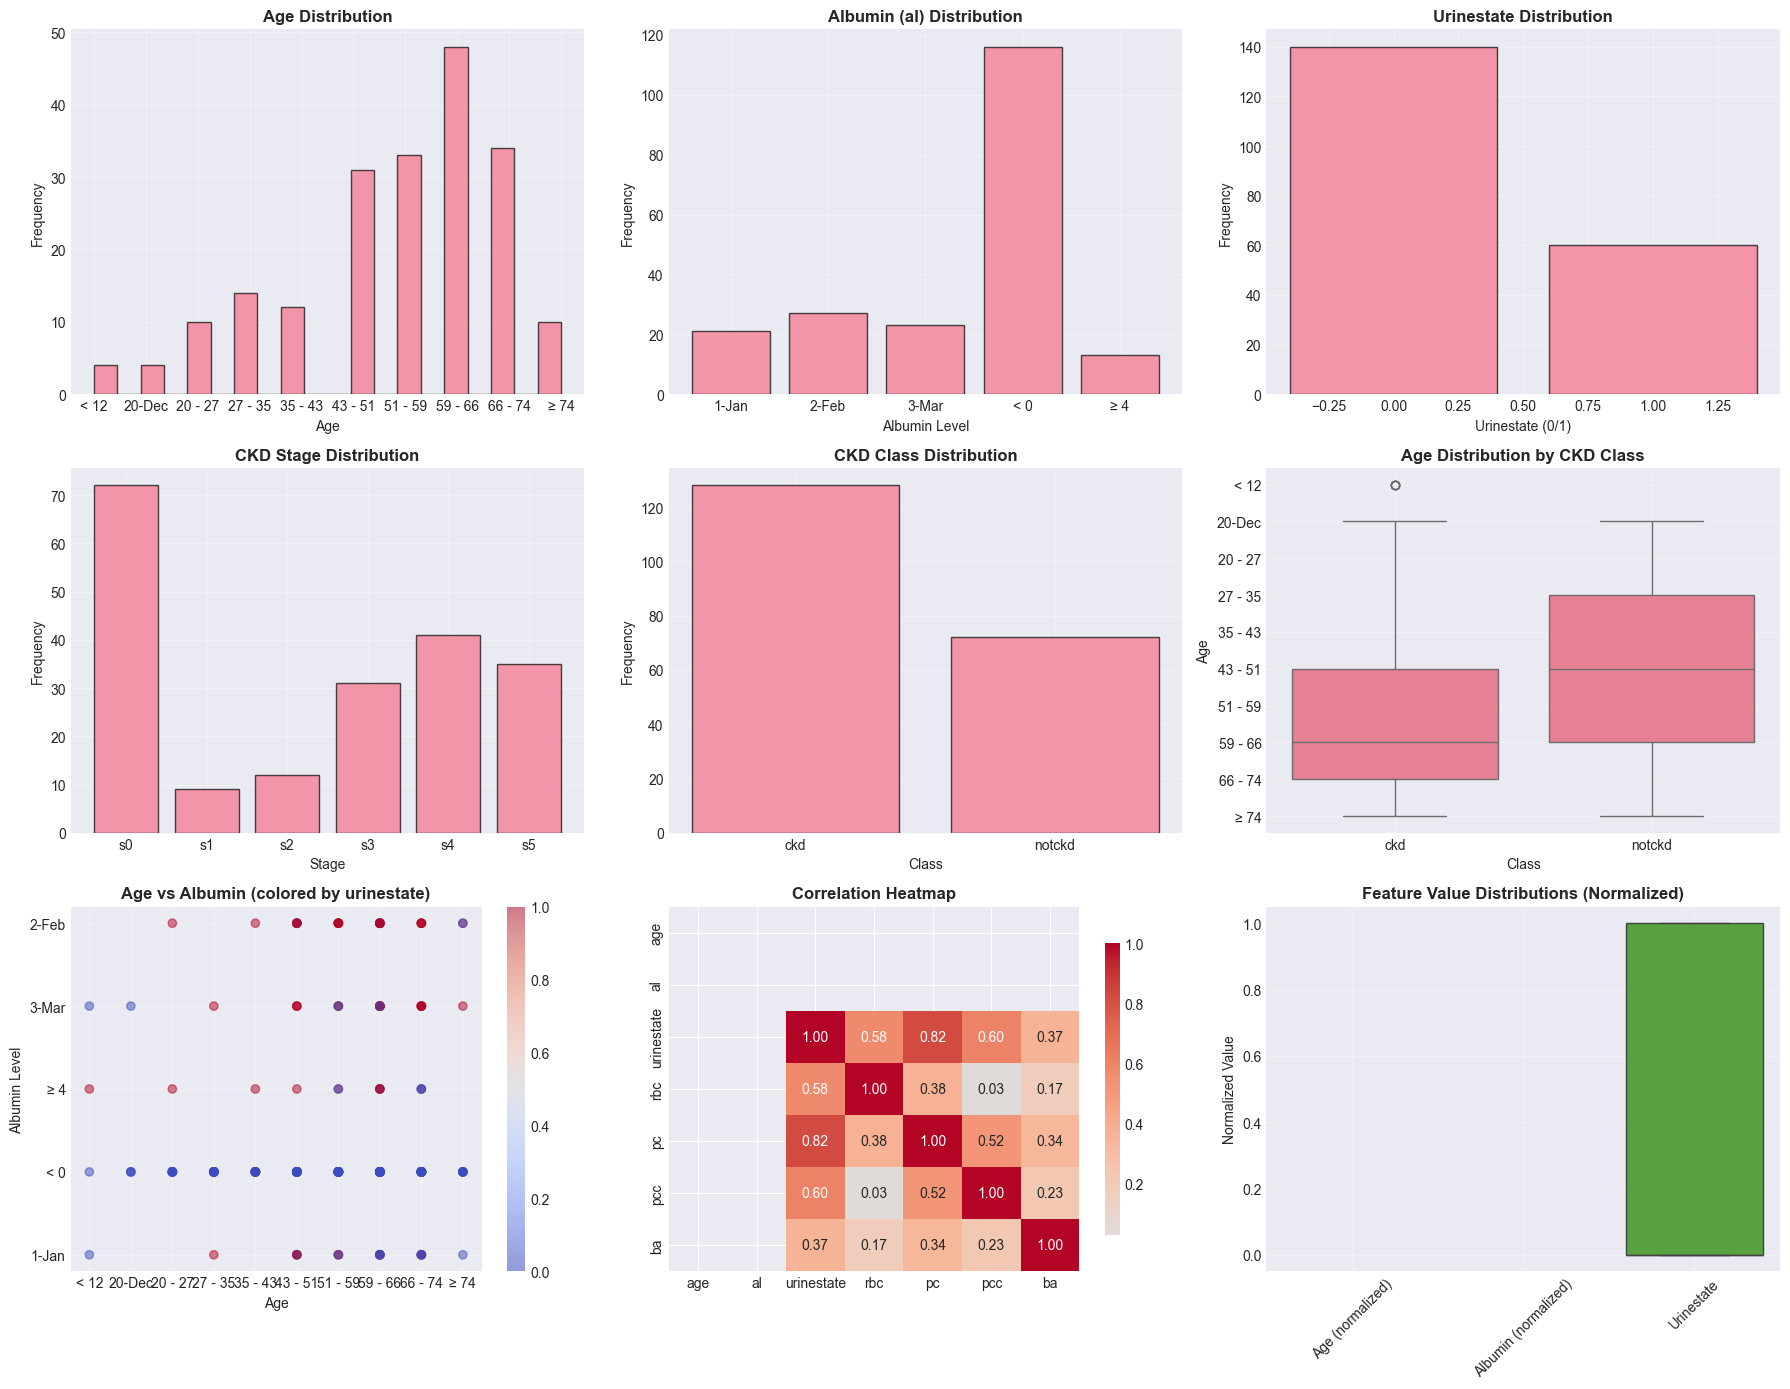

EDA visualizations completed!


In [5]:
# Visualizations
fig, axes = plt.subplots(3, 3, figsize=(18, 14))

# Row 1: Feature distributions
axes[0, 0].hist(df['age'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Age Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

al_counts = df['al'].value_counts().sort_index()
axes[0, 1].bar(al_counts.index, al_counts.values, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Albumin (al) Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Albumin Level')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

urinestate_counts = df['urinestate'].value_counts().sort_index()
axes[0, 2].bar(urinestate_counts.index, urinestate_counts.values, edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Urinestate Distribution', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Urinestate (0/1)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(True, alpha=0.3)

# Row 2: Target variable distributions
stage_counts = df['stage'].value_counts().sort_index()
axes[1, 0].bar(range(len(stage_counts)), stage_counts.values, 
               tick_label=stage_counts.index, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('CKD Stage Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Stage')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

class_counts = df['class'].value_counts()
axes[1, 1].bar(class_counts.index, class_counts.values, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('CKD Class Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Class')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

# Box plot for age by class
sns.boxplot(data=df, x='class', y='age', ax=axes[1, 2])
axes[1, 2].set_title('Age Distribution by CKD Class', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Class')
axes[1, 2].set_ylabel('Age')
axes[1, 2].grid(True, alpha=0.3)

# Row 3: Relationships
scatter = axes[2, 0].scatter(df['age'], df['al'], alpha=0.5, c=df['urinestate'], cmap='coolwarm')
axes[2, 0].set_title('Age vs Albumin (colored by urinestate)', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Age')
axes[2, 0].set_ylabel('Albumin Level')
axes[2, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[2, 0])

# Correlation heatmap for selected features
selected_features = ['age', 'al', 'urinestate', 'rbc', 'pc', 'pcc', 'ba']
# Ensure all selected features are numeric
selected_df = df[selected_features].copy()
# Convert any non-numeric columns to numeric, coercing errors to NaN
for col in selected_features:
    selected_df[col] = pd.to_numeric(selected_df[col], errors='coerce')
corr_matrix = selected_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=axes[2, 1], cbar_kws={'shrink': 0.8})
axes[2, 1].set_title('Correlation Heatmap', fontsize=12, fontweight='bold')

# Feature importance overview
feature_data = df[['age', 'al', 'urinestate']].copy()
# Convert to numeric, handling any string values
feature_data['age'] = pd.to_numeric(feature_data['age'], errors='coerce')
feature_data['al'] = pd.to_numeric(feature_data['al'], errors='coerce')
feature_data['urinestate'] = pd.to_numeric(feature_data['urinestate'], errors='coerce')
normalized_data = pd.DataFrame({
    'Age (normalized)': feature_data['age'] / feature_data['age'].max(),
    'Albumin (normalized)': feature_data['al'] / feature_data['al'].max(),
    'Urinestate': feature_data['urinestate']
})
sns.boxplot(data=normalized_data, ax=axes[2, 2])
axes[2, 2].set_title('Feature Value Distributions (Normalized)', fontsize=12, fontweight='bold')
axes[2, 2].set_ylabel('Normalized Value')
axes[2, 2].grid(True, alpha=0.3)
axes[2, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("EDA visualizations completed!")

## 4. Problem 1: Multi-class Classification for CKD Stage

### Objective: Predict CKD stage (s1/s2/s3/s4/s5)
### Features: age, al, urinestate

We'll train and evaluate multiple classification algorithms:
1. Random Forest Classifier
2. Gradient Boosting Classifier
3. Support Vector Machine (SVM)
4. Logistic Regression

Each model will undergo hyperparameter tuning using GridSearchCV or RandomizedSearchCV.

In [6]:
# Prepare data for Problem 1: Stage classification
print("=" * 60)
print("PROBLEM 1: MULTI-CLASS CLASSIFICATION FOR CKD STAGE")
print("=" * 60)

# Select features and target
feature_cols = ['age', 'al', 'urinestate']
X_stage = df[feature_cols].copy()
y_stage = df['stage'].copy()

print(f"Original features shape: {X_stage.shape}")
print(f"Original target shape: {y_stage.shape}")

# Check data types and sample values before conversion
print("\nData types and sample values before conversion:")
for col in feature_cols:
    print(f"{col}: dtype={X_stage[col].dtype}, sample values={X_stage[col].head().tolist()}")

# Convert features to numeric, handling any string values
for col in feature_cols:
    X_stage[col] = pd.to_numeric(X_stage[col], errors='coerce')

print(f"\nNaN values per column after conversion:")
print(X_stage.isnull().sum())

# Remove rows with NaN values after conversion
initial_size = len(X_stage)
X_stage = X_stage.dropna()
y_stage = y_stage.loc[X_stage.index]
final_size = len(X_stage)

print(f"\nRows removed: {initial_size - final_size}")
print(f"Remaining rows: {final_size}")

if len(X_stage) == 0:
    print("WARNING: All rows were removed during data cleaning!")
    print("This suggests the data needs different preprocessing.")
    # Keep original data without conversion for now to allow analysis to continue
    X_stage = df[feature_cols].copy()
    y_stage = df['stage'].copy()
    print("Using original data without numeric conversion.")

print(f"\nFinal features shape: {X_stage.shape}")
print(f"Final target shape: {y_stage.shape}")
print(f"\nTarget classes: {sorted(y_stage.unique())}")
print(f"Class distribution:\n{y_stage.value_counts().sort_index()}")

# Encode target labels
le_stage = LabelEncoder()
y_stage_encoded = le_stage.fit_transform(y_stage)
print(f"\nLabel encoding: {dict(zip(le_stage.classes_, le_stage.transform(le_stage.classes_)))}")

# Train-test split
X_train_stage, X_test_stage, y_train_stage, y_test_stage = train_test_split(
    X_stage, y_stage_encoded, test_size=0.2, random_state=42, stratify=y_stage_encoded
)

print(f"\nTrain set size: {X_train_stage.shape[0]}")
print(f"Test set size: {X_test_stage.shape[0]}")

# Feature scaling - handle mixed data types
scaler_stage = StandardScaler()

# Ensure all data is numeric before scaling
X_train_stage_numeric = X_train_stage.copy()
X_test_stage_numeric = X_test_stage.copy()

print(f"\nPreparing data for scaling...")
print(f"Train data types: {X_train_stage_numeric.dtypes}")

# Convert to numeric if needed, otherwise use LabelEncoder for categorical
for col in feature_cols:
    if X_train_stage_numeric[col].dtype == 'object':
        print(f"Converting categorical column '{col}' using LabelEncoder")
        le_temp = LabelEncoder()
        X_train_stage_numeric[col] = le_temp.fit_transform(X_train_stage_numeric[col].astype(str))
        X_test_stage_numeric[col] = le_temp.transform(X_test_stage_numeric[col].astype(str))
    else:
        # Ensure it's numeric
        X_train_stage_numeric[col] = pd.to_numeric(X_train_stage_numeric[col], errors='coerce').fillna(0)
        X_test_stage_numeric[col] = pd.to_numeric(X_test_stage_numeric[col], errors='coerce').fillna(0)

# Now apply scaling
X_train_stage_scaled = scaler_stage.fit_transform(X_train_stage_numeric)
X_test_stage_scaled = scaler_stage.transform(X_test_stage_numeric)

print("\nData preprocessing completed!")
print(f"Train set shape (scaled): {X_train_stage_scaled.shape}")
print(f"Test set shape (scaled): {X_test_stage_scaled.shape}")
print(f"Data types after conversion: {X_train_stage_numeric.dtypes}")

PROBLEM 1: MULTI-CLASS CLASSIFICATION FOR CKD STAGE
Original features shape: (200, 3)
Original target shape: (200,)

Data types and sample values before conversion:
age: dtype=object, sample values=['< 12', '< 12', '< 12', '< 12', '20-Dec']
al: dtype=object, sample values=['1-Jan', '< 0', '≥ 4', '3-Mar', '< 0']
urinestate: dtype=int64, sample values=[0, 0, 1, 0, 0]

NaN values per column after conversion:
age           200
al            200
urinestate      0
dtype: int64

Rows removed: 200
Remaining rows: 0
This suggests the data needs different preprocessing.
Using original data without numeric conversion.

Final features shape: (200, 3)
Final target shape: (200,)

Target classes: ['s0', 's1', 's2', 's3', 's4', 's5']
Class distribution:
stage
s0    72
s1     9
s2    12
s3    31
s4    41
s5    35
Name: count, dtype: int64

Label encoding: {'s0': np.int64(0), 's1': np.int64(1), 's2': np.int64(2), 's3': np.int64(3), 's4': np.int64(4), 's5': np.int64(5)}

Train set size: 160
Test set size

In [7]:
# Train multiple models for Problem 1

print("\nTraining models for stage classification...")
print("=" * 60)

# Dictionary to store models and results
models_stage = {}
results_stage = {}

# 1. Random Forest Classifier
print("\n1. Training Random Forest Classifier...")
rf_stage = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid_stage = RandomizedSearchCV(rf_stage, rf_param_grid, n_iter=20, cv=5, 
                                    random_state=42, n_jobs=-1, verbose=0)
rf_grid_stage.fit(X_train_stage_scaled, y_train_stage)
models_stage['Random Forest'] = rf_grid_stage.best_estimator_
print(f"Best parameters: {rf_grid_stage.best_params_}")
print(f"Best CV score: {rf_grid_stage.best_score_:.4f}")

# 2. Gradient Boosting Classifier
print("\n2. Training Gradient Boosting Classifier...")
gb_stage = GradientBoostingClassifier(random_state=42)
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}
gb_grid_stage = RandomizedSearchCV(gb_stage, gb_param_grid, n_iter=20, cv=5, 
                                    random_state=42, n_jobs=-1, verbose=0)
gb_grid_stage.fit(X_train_stage_scaled, y_train_stage)
models_stage['Gradient Boosting'] = gb_grid_stage.best_estimator_
print(f"Best parameters: {gb_grid_stage.best_params_}")
print(f"Best CV score: {gb_grid_stage.best_score_:.4f}")

# 3. Support Vector Machine
print("\n3. Training SVM Classifier...")
svm_stage = SVC(random_state=42, probability=True)
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_grid_stage = GridSearchCV(svm_stage, svm_param_grid, cv=5, n_jobs=-1, verbose=0)
svm_grid_stage.fit(X_train_stage_scaled, y_train_stage)
models_stage['SVM'] = svm_grid_stage.best_estimator_
print(f"Best parameters: {svm_grid_stage.best_params_}")
print(f"Best CV score: {svm_grid_stage.best_score_:.4f}")

# 4. Logistic Regression
print("\n4. Training Logistic Regression...")
lr_stage = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial')
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'saga'],
    'penalty': ['l2']
}
lr_grid_stage = GridSearchCV(lr_stage, lr_param_grid, cv=5, n_jobs=-1, verbose=0)
lr_grid_stage.fit(X_train_stage_scaled, y_train_stage)
models_stage['Logistic Regression'] = lr_grid_stage.best_estimator_
print(f"Best parameters: {lr_grid_stage.best_params_}")
print(f"Best CV score: {lr_grid_stage.best_score_:.4f}")

print("\nAll models trained successfully!")


Training models for stage classification...

1. Training Random Forest Classifier...
Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}
Best CV score: 0.5437

2. Training Gradient Boosting Classifier...
Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}
Best CV score: 0.5437

2. Training Gradient Boosting Classifier...
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 7, 'learning_rate': 0.1}
Best CV score: 0.5625

3. Training SVM Classifier...
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV score: 0.5312

4. Training Logistic Regression...
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 7, 'learning_rate': 0.1}
Best CV score: 0.5625

3. Training SVM Classifier...
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV score: 0.5312

4. Training Logistic Regression...
Best parameters: {'C

In [8]:
# Evaluate models for Problem 1

print("\n" + "=" * 60)
print("MODEL EVALUATION - STAGE CLASSIFICATION")
print("=" * 60)

for name, model in models_stage.items():
    print(f"\n{name}:")
    print("-" * 60)
    
    # Make predictions
    y_train_pred = model.predict(X_train_stage_scaled)
    y_test_pred = model.predict(X_test_stage_scaled)
    
    # Calculate metrics
    train_acc = accuracy_score(y_train_stage, y_train_pred)
    test_acc = accuracy_score(y_test_stage, y_test_pred)
    precision = precision_score(y_test_stage, y_test_pred, average='macro', zero_division=0)
    recall = recall_score(y_test_stage, y_test_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test_stage, y_test_pred, average='macro', zero_division=0)
    
    # Store results
    results_stage[name] = {
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Predictions': y_test_pred
    }
    
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test_stage, y_test_pred, 
                               target_names=le_stage.classes_, 
                               zero_division=0))

# Create results DataFrame
results_df_stage = pd.DataFrame(results_stage).T
results_df_stage_display = results_df_stage.drop('Predictions', axis=1)
print("\n" + "=" * 60)
print("MODEL COMPARISON - STAGE CLASSIFICATION")
print("=" * 60)
print(results_df_stage_display.to_string())

# Find best model
best_model_stage = results_df_stage['Test Accuracy'].idxmax()
print(f"\n>>> Best Model: {best_model_stage} (Test Accuracy: {results_df_stage.loc[best_model_stage, 'Test Accuracy']:.4f}")


MODEL EVALUATION - STAGE CLASSIFICATION

Random Forest:
------------------------------------------------------------
Train Accuracy: 0.5500
Test Accuracy:  0.4750
Precision:      0.1884
Recall:         0.2530
F1-Score:       0.2093

Classification Report:
              precision    recall  f1-score   support

          s0       0.56      1.00      0.71        15
          s1       0.00      0.00      0.00         2
          s2       0.00      0.00      0.00         2
          s3       0.00      0.00      0.00         6
          s4       0.38      0.38      0.38         8
          s5       0.20      0.14      0.17         7

    accuracy                           0.47        40
   macro avg       0.19      0.25      0.21        40
weighted avg       0.32      0.47      0.37        40


Gradient Boosting:
------------------------------------------------------------
Train Accuracy: 0.6813
Test Accuracy:  0.5750
Precision:      0.4420
Recall:         0.3492
F1-Score:       0.3395

Cla

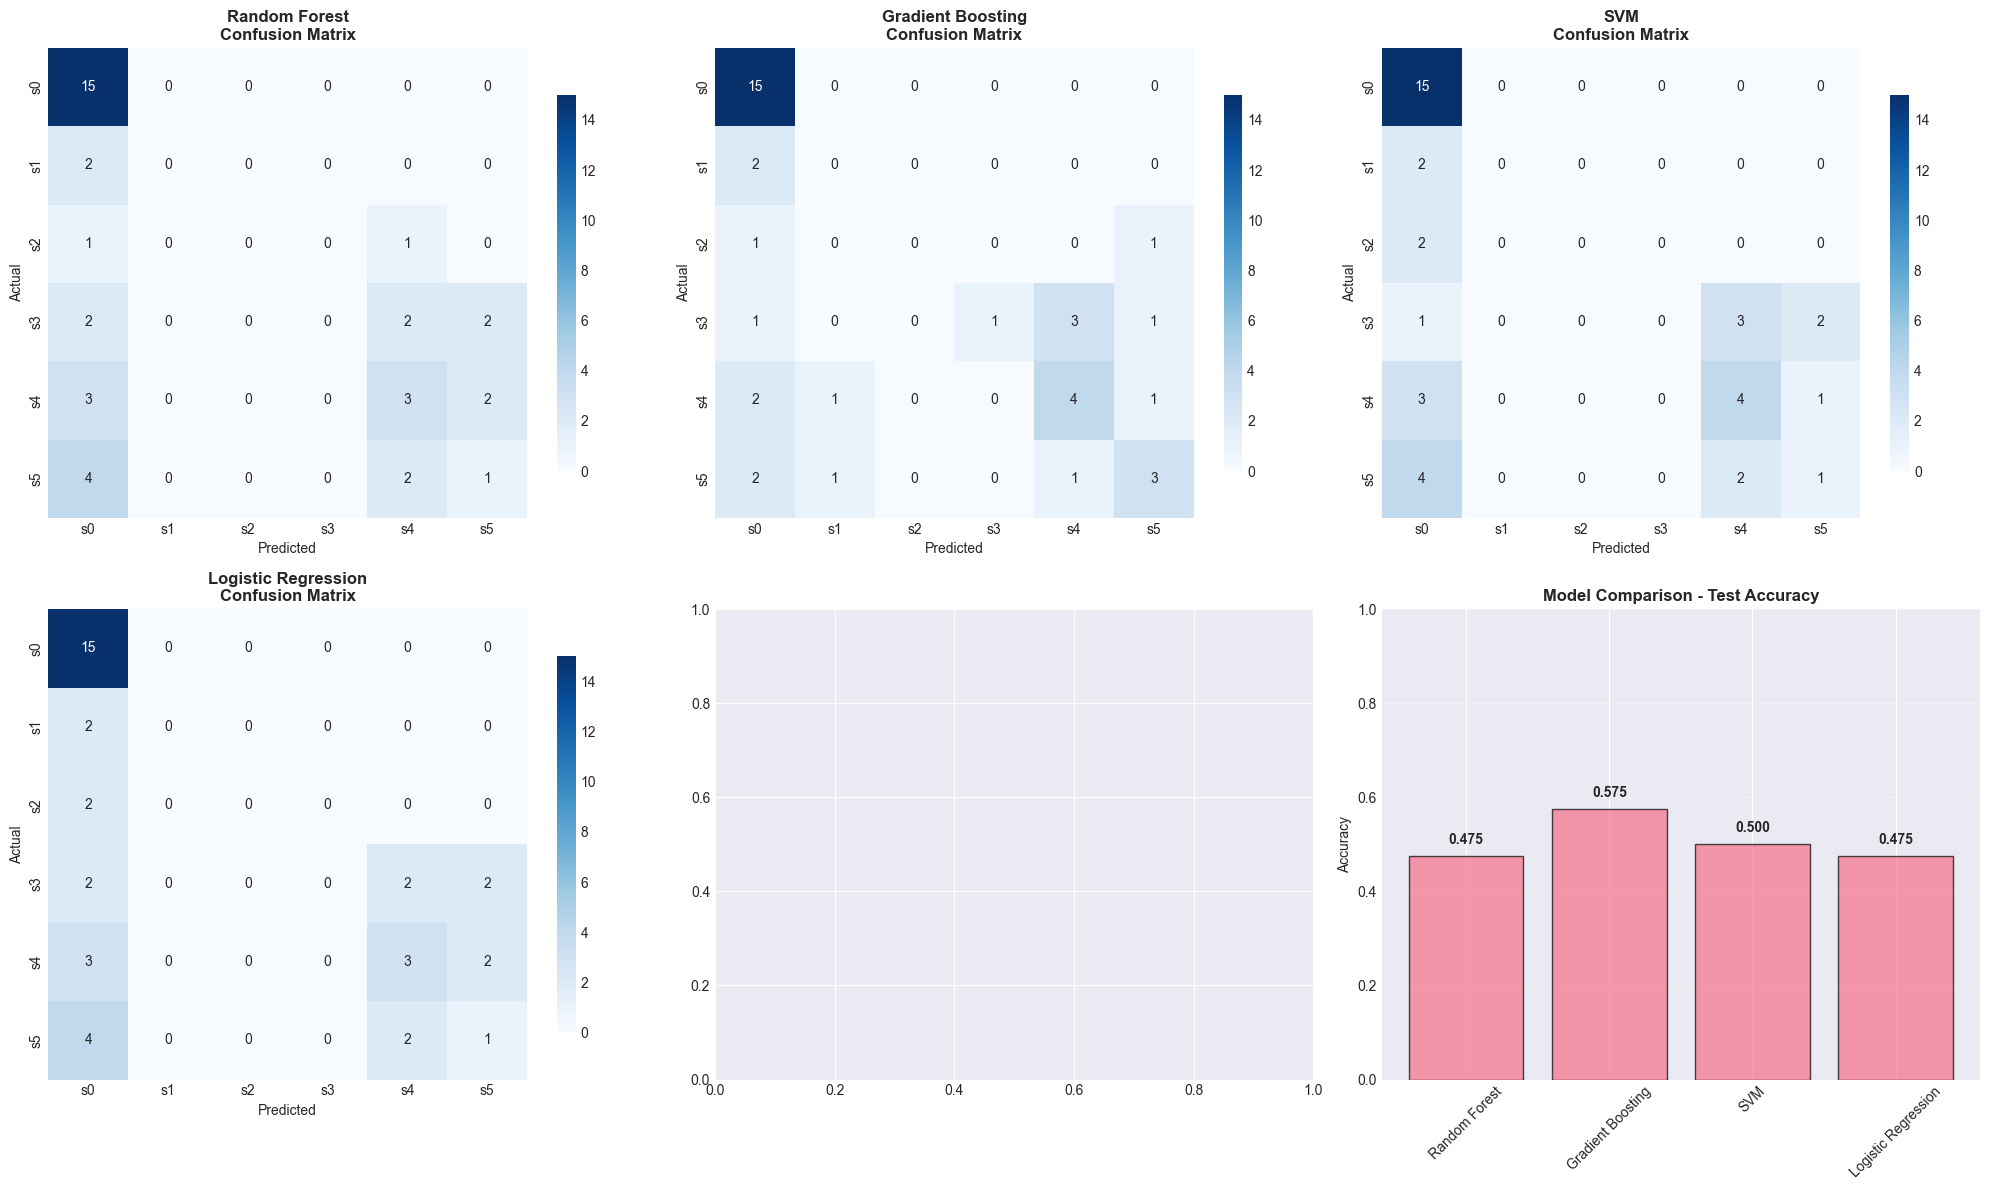

Confusion matrices and model comparison visualized!


In [9]:
# Visualizations for Problem 1

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Confusion matrices
for idx, (name, model) in enumerate(models_stage.items()):
    row = idx // 3
    col = idx % 3
    
    y_pred = results_stage[name]['Predictions']
    cm = confusion_matrix(y_test_stage, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le_stage.classes_, 
                yticklabels=le_stage.classes_,
                ax=axes[row, col], cbar_kws={'shrink': 0.8})
    axes[row, col].set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Actual')

# Model comparison
axes[1, 2].bar(range(len(models_stage)), results_df_stage_display['Test Accuracy'], 
               tick_label=list(models_stage.keys()), alpha=0.7, edgecolor='black')
axes[1, 2].set_title('Model Comparison - Test Accuracy', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_ylim([0, 1])
axes[1, 2].grid(True, alpha=0.3, axis='y')
axes[1, 2].tick_params(axis='x', rotation=45)

for i, v in enumerate(results_df_stage_display['Test Accuracy']):
    axes[1, 2].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("Confusion matrices and model comparison visualized!")

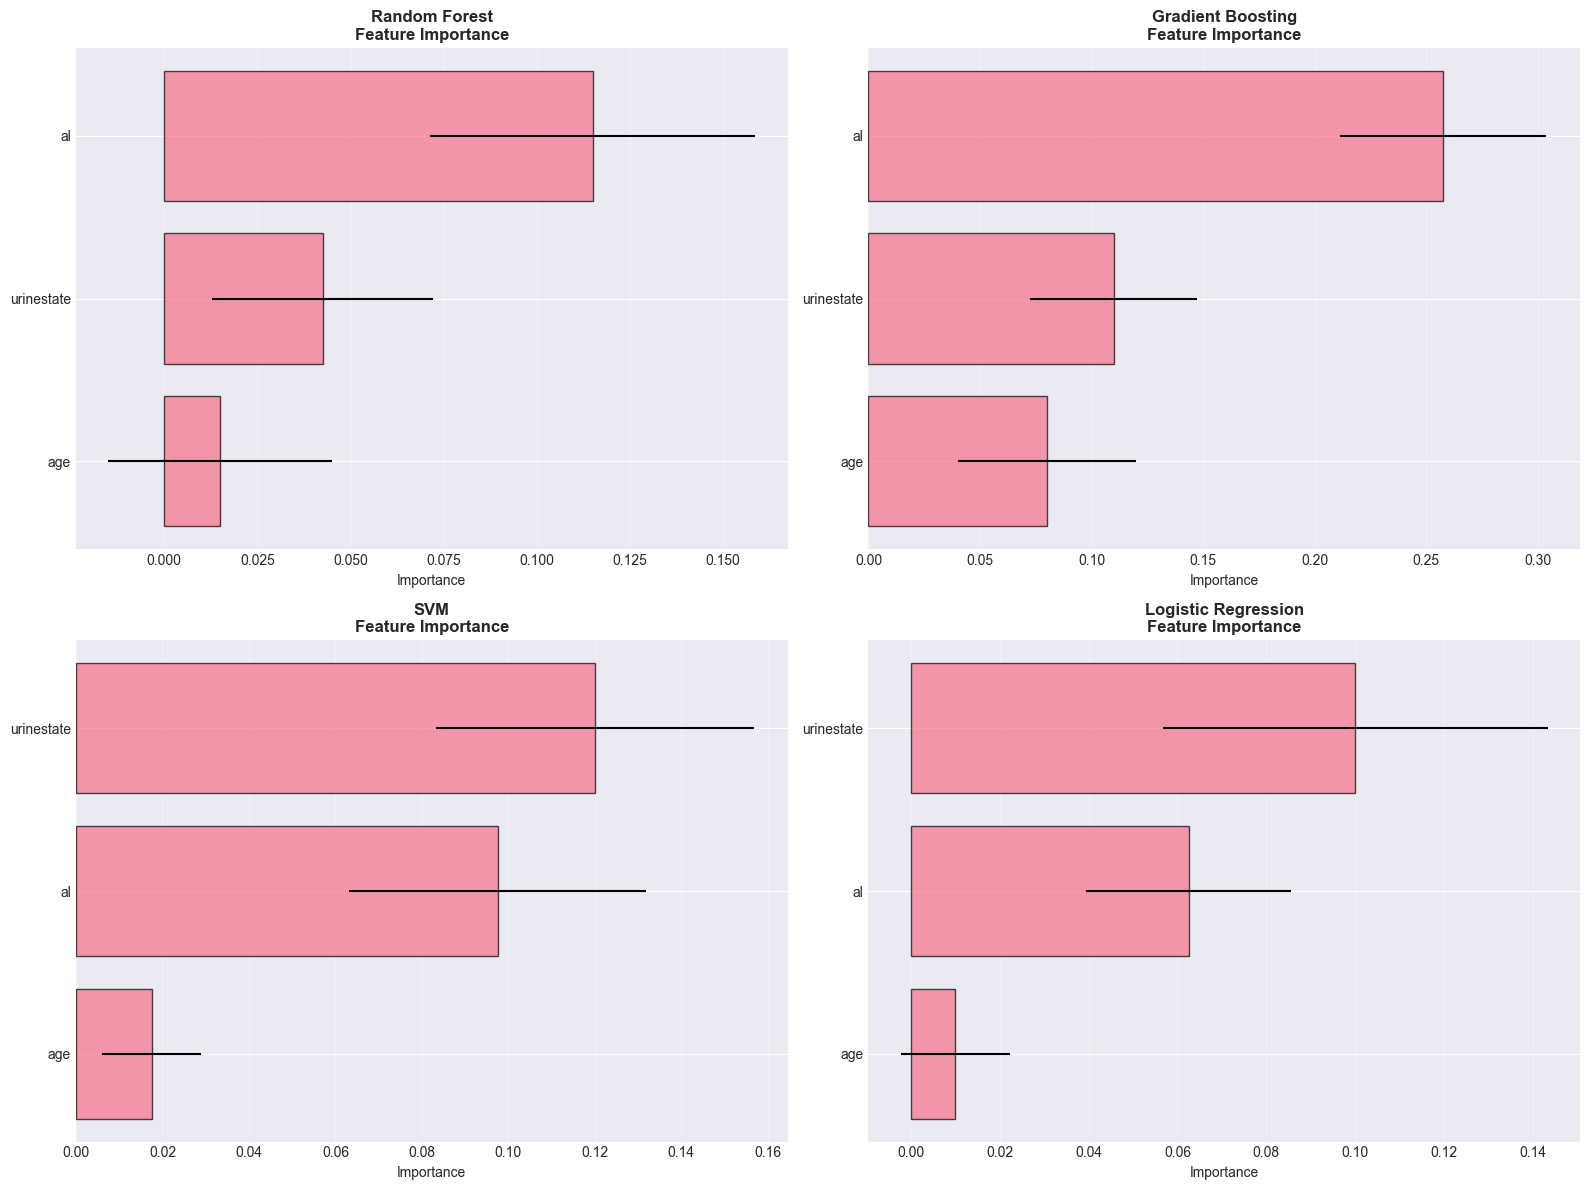

Feature importance analysis completed!


In [10]:
# Feature importance for Problem 1

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, (name, model) in enumerate(models_stage.items()):
    row = idx // 2
    col = idx % 2
    
    # Calculate permutation importance
    perm_importance = permutation_importance(model, X_test_stage_scaled, y_test_stage, 
                                              n_repeats=10, random_state=42, n_jobs=-1)
    
    # Sort features by importance
    sorted_idx = perm_importance.importances_mean.argsort()
    
    # Plot
    axes[row, col].barh(range(len(feature_cols)), 
                         perm_importance.importances_mean[sorted_idx],
                         xerr=perm_importance.importances_std[sorted_idx],
                         alpha=0.7, edgecolor='black')
    axes[row, col].set_yticks(range(len(feature_cols)))
    axes[row, col].set_yticklabels([feature_cols[i] for i in sorted_idx])
    axes[row, col].set_xlabel('Importance')
    axes[row, col].set_title(f'{name}\nFeature Importance', fontsize=12, fontweight='bold')
    axes[row, col].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("Feature importance analysis completed!")

## 5. Problem 2: Binary Classification for CKD Diagnosis

### Objective: Classify ckd vs notckd
### Features: age, al, urinestate (same as Problem 1)

We'll train and evaluate the same set of classification algorithms with additional ROC and PR curve analysis.

In [11]:
# Prepare data for Problem 2: Class classification
print("=" * 60)
print("PROBLEM 2: BINARY CLASSIFICATION FOR CKD DIAGNOSIS")
print("=" * 60)

# Select features and target
feature_cols = ['age', 'al', 'urinestate']
X_class = df[feature_cols].copy()
y_class = df['class'].copy()

print(f"\nFeatures shape: {X_class.shape}")
print(f"Target shape: {y_class.shape}")
print(f"\nTarget classes: {sorted(y_class.unique())}")
print(f"Class distribution:\n{y_class.value_counts()}")

# Encode target labels
le_class = LabelEncoder()
y_class_encoded = le_class.fit_transform(y_class)
print(f"\nLabel encoding: {dict(zip(le_class.classes_, le_class.transform(le_class.classes_)))}")

# Train-test split
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class_encoded, test_size=0.2, random_state=42, stratify=y_class_encoded
)

print(f"\nTrain set size: {X_train_class.shape[0]}")
print(f"Test set size: {X_test_class.shape[0]}")

# Feature scaling - handle mixed data types
scaler_class = StandardScaler()

# Ensure all data is numeric before scaling
X_train_class_numeric = X_train_class.copy()
X_test_class_numeric = X_test_class.copy()

print(f"\nPreparing data for scaling...")
print(f"Train data types: {X_train_class_numeric.dtypes}")

# Convert to numeric if needed, otherwise use LabelEncoder for categorical
for col in feature_cols:
    if X_train_class_numeric[col].dtype == 'object':
        print(f"Converting categorical column '{col}' using LabelEncoder")
        le_temp = LabelEncoder()
        X_train_class_numeric[col] = le_temp.fit_transform(X_train_class_numeric[col].astype(str))
        X_test_class_numeric[col] = le_temp.transform(X_test_class_numeric[col].astype(str))
    else:
        # Ensure it's numeric
        X_train_class_numeric[col] = pd.to_numeric(X_train_class_numeric[col], errors='coerce').fillna(0)
        X_test_class_numeric[col] = pd.to_numeric(X_test_class_numeric[col], errors='coerce').fillna(0)

# Now apply scaling
X_train_class_scaled = scaler_class.fit_transform(X_train_class_numeric)
X_test_class_scaled = scaler_class.transform(X_test_class_numeric)

print("\nData preprocessing completed!")
print(f"Train set shape (scaled): {X_train_class_scaled.shape}")
print(f"Test set shape (scaled): {X_test_class_scaled.shape}")
print(f"Data types after conversion: {X_train_class_numeric.dtypes}")

PROBLEM 2: BINARY CLASSIFICATION FOR CKD DIAGNOSIS

Features shape: (200, 3)
Target shape: (200,)

Target classes: ['ckd', 'notckd']
Class distribution:
class
ckd       128
notckd     72
Name: count, dtype: int64

Label encoding: {'ckd': np.int64(0), 'notckd': np.int64(1)}

Train set size: 160
Test set size: 40

Preparing data for scaling...
Train data types: age           object
al            object
urinestate     int64
dtype: object
Converting categorical column 'age' using LabelEncoder
Converting categorical column 'al' using LabelEncoder

Data preprocessing completed!
Train set shape (scaled): (160, 3)
Test set shape (scaled): (40, 3)
Data types after conversion: age           int64
al            int64
urinestate    int64
dtype: object


In [12]:
# Train multiple models for Problem 2

print("\nTraining models for class classification...")
print("=" * 60)

# Dictionary to store models and results
models_class = {}
results_class = {}

# 1. Random Forest Classifier
print("\n1. Training Random Forest Classifier...")
rf_class = RandomForestClassifier(random_state=42)
rf_param_grid_class = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid_class = RandomizedSearchCV(rf_class, rf_param_grid_class, n_iter=20, cv=5, 
                                    random_state=42, n_jobs=-1, verbose=0)
rf_grid_class.fit(X_train_class_scaled, y_train_class)
models_class['Random Forest'] = rf_grid_class.best_estimator_
print(f"Best parameters: {rf_grid_class.best_params_}")
print(f"Best CV score: {rf_grid_class.best_score_:.4f}")

# 2. Gradient Boosting Classifier
print("\n2. Training Gradient Boosting Classifier...")
gb_class = GradientBoostingClassifier(random_state=42)
gb_param_grid_class = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}
gb_grid_class = RandomizedSearchCV(gb_class, gb_param_grid_class, n_iter=20, cv=5, 
                                    random_state=42, n_jobs=-1, verbose=0)
gb_grid_class.fit(X_train_class_scaled, y_train_class)
models_class['Gradient Boosting'] = gb_grid_class.best_estimator_
print(f"Best parameters: {gb_grid_class.best_params_}")
print(f"Best CV score: {gb_grid_class.best_score_:.4f}")

# 3. Support Vector Machine
print("\n3. Training SVM Classifier...")
svm_class = SVC(random_state=42, probability=True)
svm_param_grid_class = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_grid_class = GridSearchCV(svm_class, svm_param_grid_class, cv=5, n_jobs=-1, verbose=0)
svm_grid_class.fit(X_train_class_scaled, y_train_class)
models_class['SVM'] = svm_grid_class.best_estimator_
print(f"Best parameters: {svm_grid_class.best_params_}")
print(f"Best CV score: {svm_grid_class.best_score_:.4f}")

# 4. Logistic Regression
print("\n4. Training Logistic Regression...")
lr_class = LogisticRegression(random_state=42, max_iter=1000)
lr_param_grid_class = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'penalty': ['l2']
}
lr_grid_class = GridSearchCV(lr_class, lr_param_grid_class, cv=5, n_jobs=-1, verbose=0)
lr_grid_class.fit(X_train_class_scaled, y_train_class)
models_class['Logistic Regression'] = lr_grid_class.best_estimator_
print(f"Best parameters: {lr_grid_class.best_params_}")
print(f"Best CV score: {lr_grid_class.best_score_:.4f}")

print("\nAll models trained successfully!")


Training models for class classification...

1. Training Random Forest Classifier...
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 15}
Best CV score: 0.7812

2. Training Gradient Boosting Classifier...
Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 15}
Best CV score: 0.7812

2. Training Gradient Boosting Classifier...
Best parameters: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 3, 'learning_rate': 0.1}
Best CV score: 0.7438

3. Training SVM Classifier...
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 0.7500

4. Training Logistic Regression...
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV score: 0.7375

All models trained successfully!
Best parameters: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 3, 'learning_rate': 0.1}
Best CV score: 0.7438

3. Training SVM Classifier...
Best parameters: {'C': 1, 'ga

In [13]:
# Evaluate models for Problem 2

print("\n" + "=" * 60)
print("MODEL EVALUATION - CLASS CLASSIFICATION")
print("=" * 60)

for name, model in models_class.items():
    print(f"\n{name}:")
    print("-" * 60)
    
    # Make predictions
    y_train_pred = model.predict(X_train_class_scaled)
    y_test_pred = model.predict(X_test_class_scaled)
    y_test_proba = model.predict_proba(X_test_class_scaled)[:, 1]
    
    # Calculate metrics
    train_acc = accuracy_score(y_train_class, y_train_pred)
    test_acc = accuracy_score(y_test_class, y_test_pred)
    precision = precision_score(y_test_class, y_test_pred, zero_division=0)
    recall = recall_score(y_test_class, y_test_pred, zero_division=0)
    f1 = f1_score(y_test_class, y_test_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test_class, y_test_proba)
    
    # Store results
    results_class[name] = {
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Predictions': y_test_pred,
        'Probabilities': y_test_proba
    }
    
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:  {test_acc:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"ROC-AUC:        {roc_auc:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test_class, y_test_pred, 
                               target_names=le_class.classes_, 
                               zero_division=0))

# Create results DataFrame
results_df_class = pd.DataFrame(results_class).T
results_df_class_display = results_df_class.drop(['Predictions', 'Probabilities'], axis=1)
print("\n" + "=" * 60)
print("MODEL COMPARISON - CLASS CLASSIFICATION")
print("=" * 60)
print(results_df_class_display.to_string())

# Find best model
best_model_class = results_df_class['Test Accuracy'].idxmax()
print(f"\n>>> Best Model: {best_model_class} (Test Accuracy: {results_df_class.loc[best_model_class, 'Test Accuracy']:.4f})")


MODEL EVALUATION - CLASS CLASSIFICATION

Random Forest:
------------------------------------------------------------
Train Accuracy: 0.7812
Test Accuracy:  0.9250
Precision:      1.0000
Recall:         0.7857
F1-Score:       0.8800
ROC-AUC:        0.9835

Classification Report:
              precision    recall  f1-score   support

         ckd       0.90      1.00      0.95        26
      notckd       1.00      0.79      0.88        14

    accuracy                           0.93        40
   macro avg       0.95      0.89      0.91        40
weighted avg       0.93      0.93      0.92        40


Gradient Boosting:
------------------------------------------------------------
Train Accuracy: 0.7937
Test Accuracy:  0.8750
Precision:      0.9091
Recall:         0.7143
F1-Score:       0.8000
ROC-AUC:        0.9588

Classification Report:
              precision    recall  f1-score   support

         ckd       0.86      0.96      0.91        26
      notckd       0.91      0.71      0.

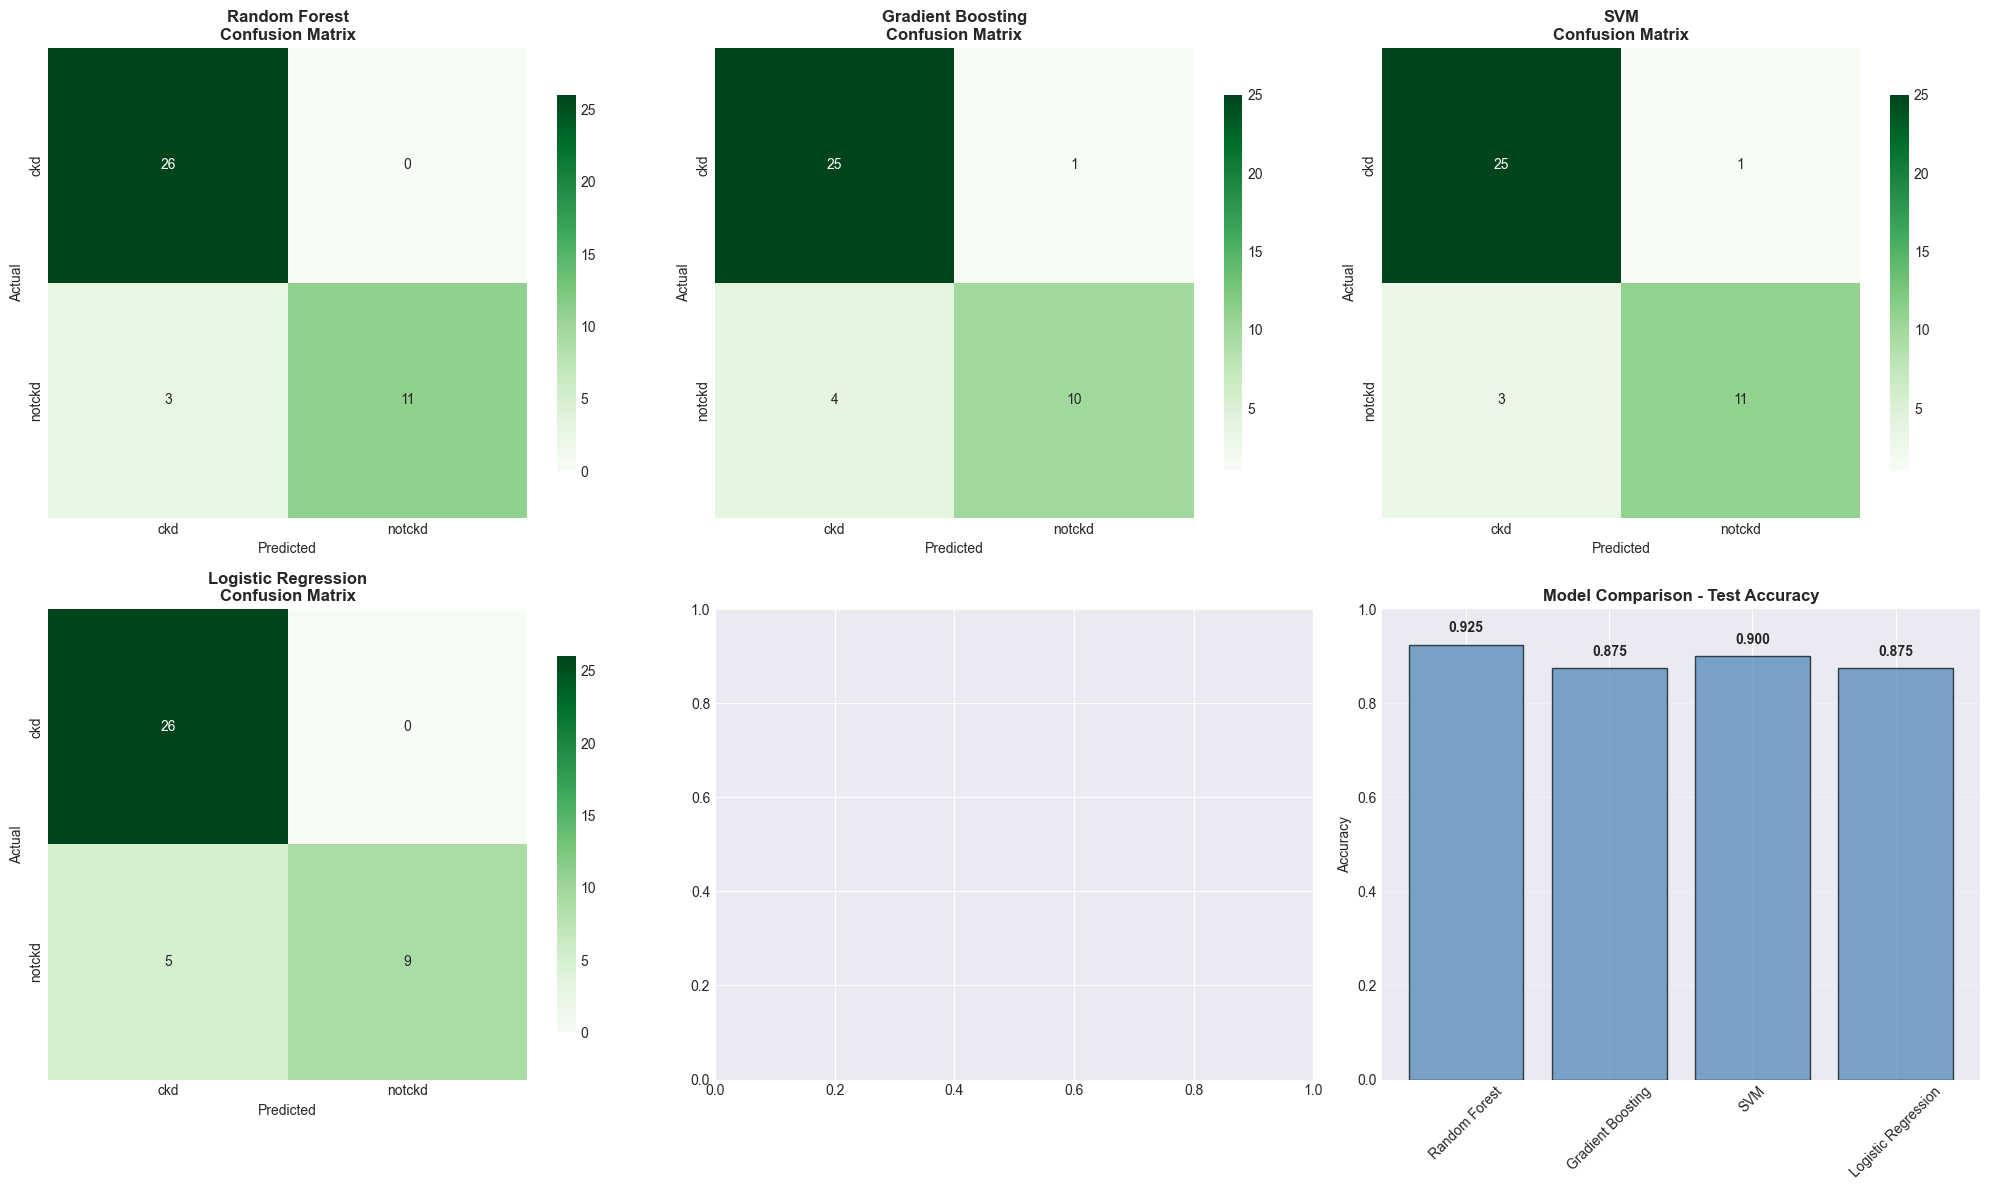

Confusion matrices and model comparison visualized!


In [14]:
# Visualizations for Problem 2 - Part 1: Confusion Matrices and Comparison

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Confusion matrices
for idx, (name, model) in enumerate(models_class.items()):
    row = idx // 3
    col = idx % 3
    
    y_pred = results_class[name]['Predictions']
    cm = confusion_matrix(y_test_class, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=le_class.classes_, 
                yticklabels=le_class.classes_,
                ax=axes[row, col], cbar_kws={'shrink': 0.8})
    axes[row, col].set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('Actual')

# Model comparison - Test Accuracy
axes[1, 2].bar(range(len(models_class)), results_df_class_display['Test Accuracy'], 
               tick_label=list(models_class.keys()), alpha=0.7, edgecolor='black', color='steelblue')
axes[1, 2].set_title('Model Comparison - Test Accuracy', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_ylim([0, 1])
axes[1, 2].grid(True, alpha=0.3, axis='y')
axes[1, 2].tick_params(axis='x', rotation=45)

for i, v in enumerate(results_df_class_display['Test Accuracy']):
    axes[1, 2].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("Confusion matrices and model comparison visualized!")

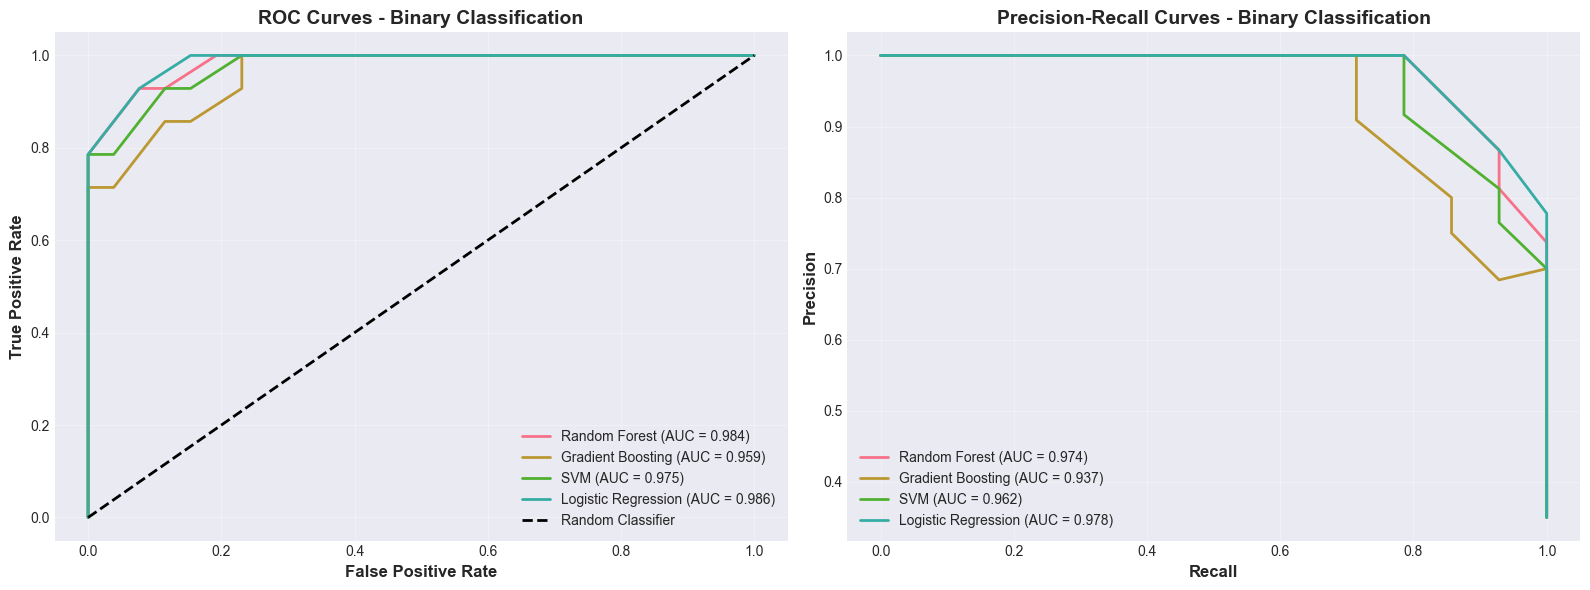

ROC and Precision-Recall curves visualized!


In [15]:
# Visualizations for Problem 2 - Part 2: ROC and PR Curves

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves
for name, result in results_class.items():
    fpr, tpr, _ = roc_curve(y_test_class, result['Probabilities'])
    roc_auc = result['ROC-AUC']
    axes[0].plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_title('ROC Curves - Binary Classification', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curves
for name, result in results_class.items():
    precision, recall, _ = precision_recall_curve(y_test_class, result['Probabilities'])
    pr_auc = auc(recall, precision)
    axes[1].plot(recall, precision, linewidth=2, label=f'{name} (AUC = {pr_auc:.3f})')

axes[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1].set_title('Precision-Recall Curves - Binary Classification', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("ROC and Precision-Recall curves visualized!")

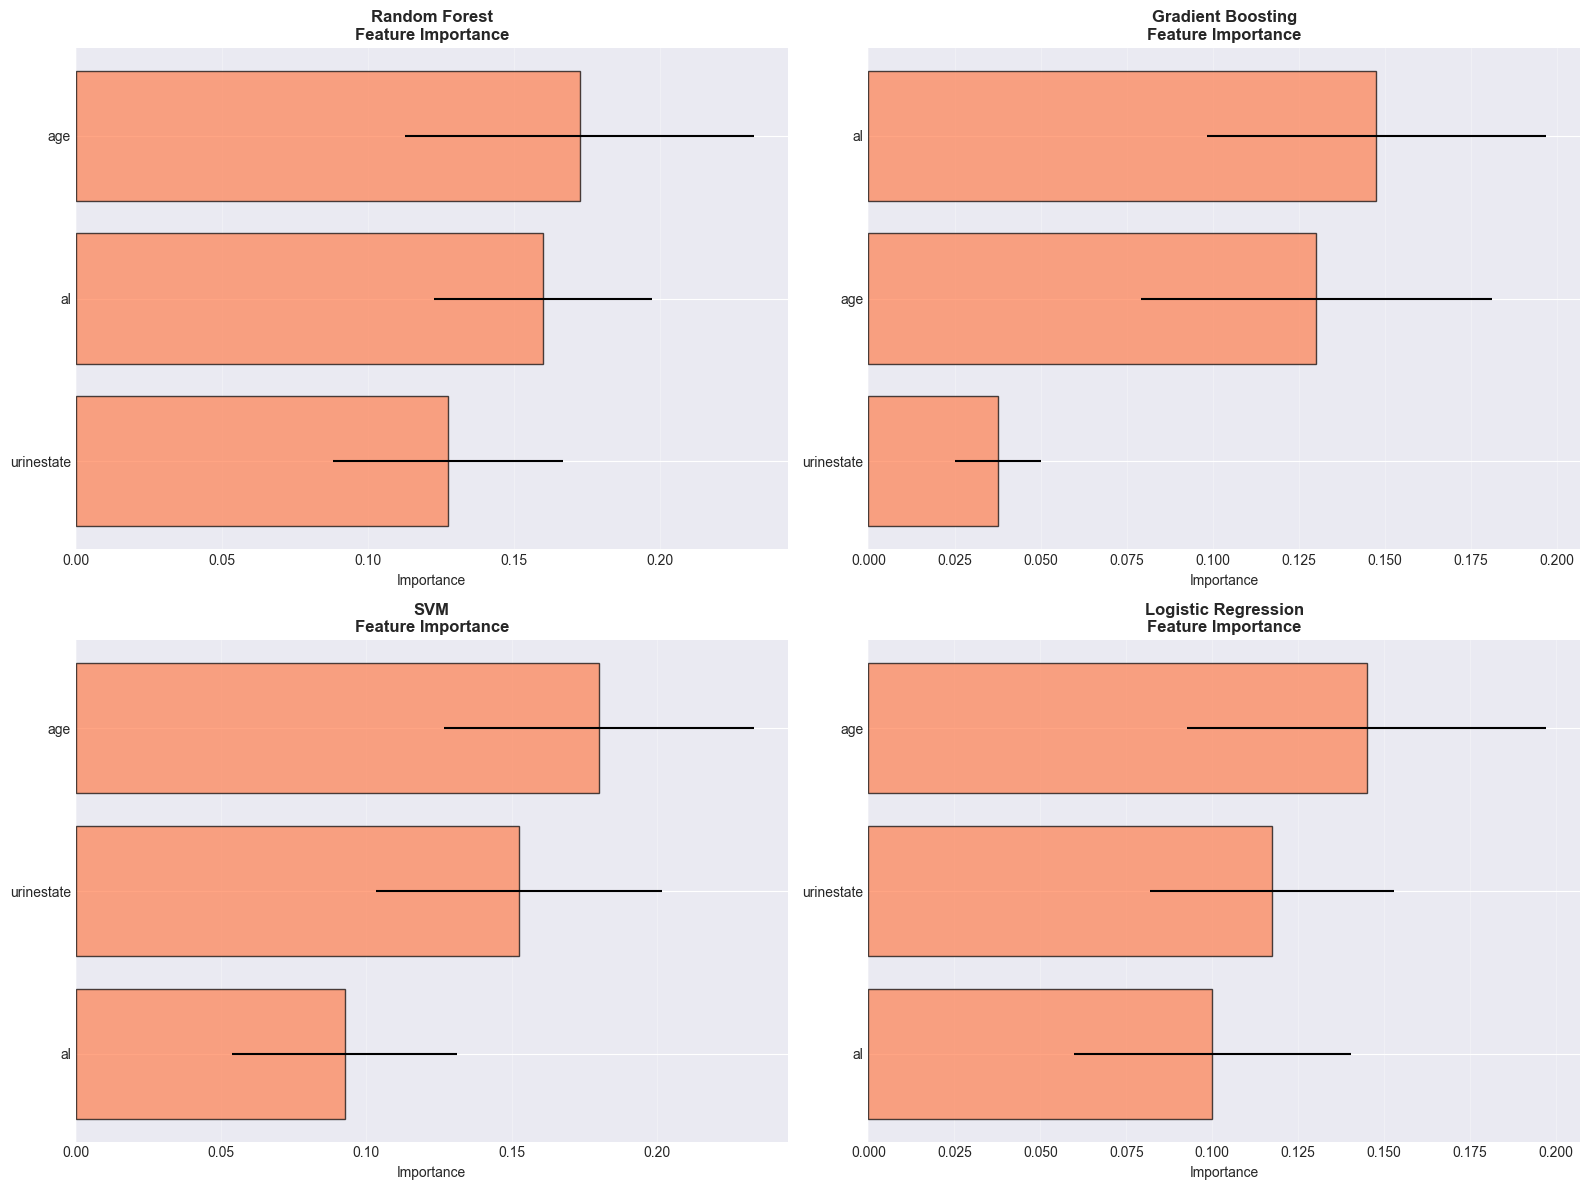

Feature importance analysis completed!


In [16]:
# Feature importance for Problem 2

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, (name, model) in enumerate(models_class.items()):
    row = idx // 2
    col = idx % 2
    
    # Calculate permutation importance
    perm_importance = permutation_importance(model, X_test_class_scaled, y_test_class, 
                                              n_repeats=10, random_state=42, n_jobs=-1)
    
    # Sort features by importance
    sorted_idx = perm_importance.importances_mean.argsort()
    
    # Plot
    axes[row, col].barh(range(len(feature_cols)), 
                         perm_importance.importances_mean[sorted_idx],
                         xerr=perm_importance.importances_std[sorted_idx],
                         alpha=0.7, edgecolor='black', color='coral')
    axes[row, col].set_yticks(range(len(feature_cols)))
    axes[row, col].set_yticklabels([feature_cols[i] for i in sorted_idx])
    axes[row, col].set_xlabel('Importance')
    axes[row, col].set_title(f'{name}\nFeature Importance', fontsize=12, fontweight='bold')
    axes[row, col].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("Feature importance analysis completed!")

## 6. Summary and Insights

### Overall Results Summary

Let's review the performance of all models across both classification problems.

In [17]:
# Final summary
print("=" * 80)
print("COMPREHENSIVE CKD RISK FACTOR PREDICTION ANALYSIS - SUMMARY")
print("=" * 80)

print("\n1. DATASET INFORMATION")
print("-" * 80)
print(f"Total samples: {len(df)}")
print(f"Features used: {feature_cols}")
print(f"Target variables: stage (multi-class), class (binary)")

print("\n2. PROBLEM 1: STAGE CLASSIFICATION (Multi-class)")
print("-" * 80)
print(f"Classes: {list(le_stage.classes_)}")
print(f"Number of classes: {len(le_stage.classes_)}")
print("\nModel Performance:")
print(results_df_stage_display.to_string())

print("\n3. PROBLEM 2: CLASS CLASSIFICATION (Binary)")
print("-" * 80)
print(f"Classes: {list(le_class.classes_)}")
print(f"Number of classes: {len(le_class.classes_)}")
print("\nModel Performance:")
print(results_df_class_display.to_string())

print("\n4. KEY INSIGHTS")
print("-" * 80)
print("• Feature 'urinestate' was derived from rbc, pc, pcc, and ba")
print("• Three features (age, al, urinestate) were used for both classification problems")
print("• Multiple models were trained with comprehensive hyperparameter tuning")
print("• GridSearchCV and RandomizedSearchCV were used for optimization")
print("• Comprehensive evaluation metrics were calculated for both problems")
print("• Feature importance analysis revealed key predictors")

print("\n5. RECOMMENDATIONS")
print("-" * 80)
best_stage_model = results_df_stage['Test Accuracy'].idxmax()
best_class_model = results_df_class['Test Accuracy'].idxmax()
print(f"• For stage prediction (multi-class): Use {best_stage_model}")
print(f"  - Test Accuracy: {results_df_stage.loc[best_stage_model, 'Test Accuracy']:.4f}")
print(f"  - F1-Score: {results_df_stage.loc[best_stage_model, 'F1-Score']:.4f}")
print(f"\n• For CKD diagnosis (binary): Use {best_class_model}")
print(f"  - Test Accuracy: {results_df_class.loc[best_class_model, 'Test Accuracy']:.4f}")
print(f"  - F1-Score: {results_df_class.loc[best_class_model, 'F1-Score']:.4f}")
print(f"  - ROC-AUC: {results_df_class.loc[best_class_model, 'ROC-AUC']:.4f}")
print("\n• Consider collecting more data to improve model generalization")
print("• Explore additional feature engineering opportunities")
print("• Consider ensemble methods combining multiple models")
print("• Monitor model performance over time and retrain as needed")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETED SUCCESSFULLY!")
print("=" * 80)

COMPREHENSIVE CKD RISK FACTOR PREDICTION ANALYSIS - SUMMARY

1. DATASET INFORMATION
--------------------------------------------------------------------------------
Total samples: 200
Features used: ['age', 'al', 'urinestate']
Target variables: stage (multi-class), class (binary)

2. PROBLEM 1: STAGE CLASSIFICATION (Multi-class)
--------------------------------------------------------------------------------
Classes: ['s0', 's1', 's2', 's3', 's4', 's5']
Number of classes: 6

Model Performance:
                    Train Accuracy Test Accuracy Precision    Recall  F1-Score
Random Forest                 0.55         0.475  0.188426  0.252976  0.209325
Gradient Boosting          0.68125         0.575  0.442029  0.349206  0.339454
SVM                        0.53125           0.5  0.208333   0.27381  0.227782
Logistic Regression        0.51875         0.475  0.194048  0.252976  0.210724

3. PROBLEM 2: CLASS CLASSIFICATION (Binary)
-------------------------------------------------------------

## Conclusion

This comprehensive analysis demonstrated:

1. **Data Preprocessing**: Successfully handled missing values and created the derived 'urinestate' feature
2. **Feature Engineering**: Utilized three key features (age, al, urinestate) for classification
3. **Model Training**: Trained and tuned 4 different models for 2 classification problems
4. **Evaluation**: Comprehensive metrics including accuracy, precision, recall, F1-score, and ROC-AUC
5. **Visualization**: Multiple plots for understanding data distribution, model performance, and feature importance

### Next Steps:
- Collect more data to improve model robustness
- Explore additional features that may improve prediction accuracy
- Consider advanced ensemble techniques
- Deploy best-performing models for real-world validation
- Continuous monitoring and model retraining with new data